In [1]:
!pip -V

pip 24.2 from /Users/saksham/AI/Deep_Learning/LLM/llm-p3.12/lib/python3.12/site-packages/pip (python 3.12)


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def f(x):
    return 3*x**2-4*x+1

In [4]:
f(2)

5

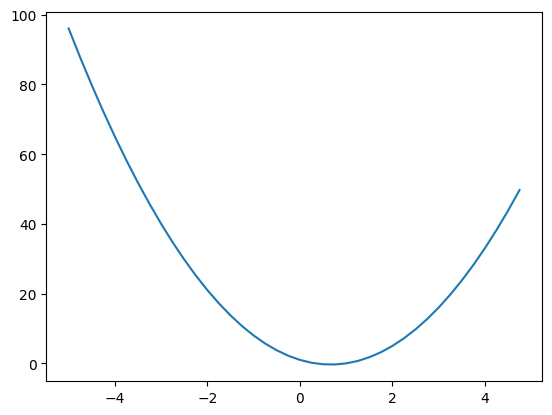

In [5]:

xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [6]:
h = 0.0001
x = 3
(f(x+h)-f(x))/h

14.000300000063248

In [7]:
a=2
b=4
c=5

d1=a*b+c
c+=h
d2=a*b+c

print(d1)
print(d2)
(d2-d1)/h

13
13.0001


0.9999999999976694

In [8]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self.grad = 0.0
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(Data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self*other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    
    def tanh(self):
        out = Value(np.tanh(self.data), (self,), "tanh")
        
        def _backward():
            self.grad+= 1.0 * (1 - out.data ** 2) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"


In [9]:
from graphviz import Digraph
# Helper functions
def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f"{{ {n.label} | data {n.data:.4f} | grad {n.grad:.4f} }}", shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

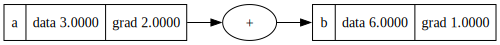

In [10]:
a = Value(3.0, label='a')
b = a+a
b.label = "b"
b.grad = 1.0

b.backward()
draw_dot(b)

In [18]:
#Inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
#Weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
#Bias
b = Value(6.8813735870195432, label="b")

x1w1 = x1*w1 
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1+ x2w2
x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b 
n.label = "n"
o = n.tanh()
o.label = "o"

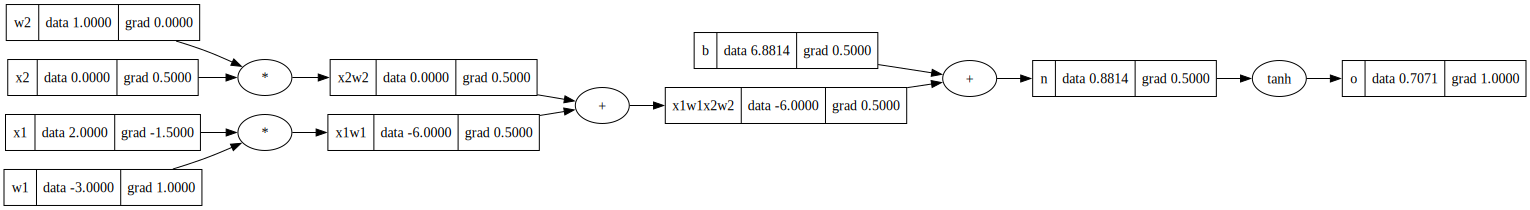

In [21]:
draw_dot(o)

In [20]:
o.backward()

In [16]:
import torch

In [22]:

x1 = torch. Tensor ([2.0]). double() 
x2 = torch. Tensor ( [0.0]). double() 
w1 = torch.Tensor([-3.0]).double() 
w2 = torch. Tensor ([1.0]).double()
x1.requires_grad= True ; 
x2.requires_grad= True ; 
w1.requires_grad= True ;
w2.requires_grad= True ;

b = torch. Tensor ([6.8813735870195432]). double(); 
b.requires_grad= True 
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print (o.data.item()) 
o.backward()
print('---')
print('x2', x2.grad.item()) 
print('w2', w2.grad.item()) 
print('x1', x1.grad.item()) 
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [42]:
import random


class Neuron():
    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act
    
    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"
    
class Layer():
    def __init__(self,nin,nout,**kwargs):
        self.neurons = [Neuron(nin,**kwargs) for _ in range(nout)]
        
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"
    
class MLP():
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"


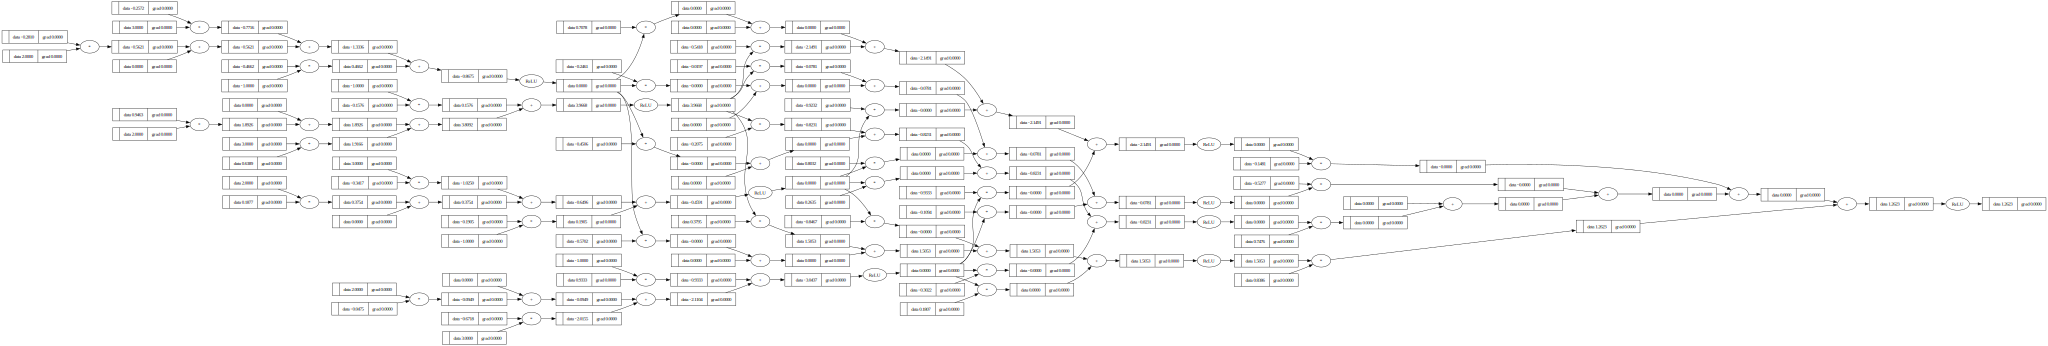

In [88]:
draw_dot(n(x))

In [233]:
    
# x = [2.0,3.0, -1.0]    
n = MLP(3,[4,4,1])
len(n.parameters())

41

In [234]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5, 1.0, 1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0]

In [236]:
for k in range(100):
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
    
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.05*p.grad
        
    print(k," loss ->", loss.data)

0  loss -> 4.0
1  loss -> 4.0
2  loss -> 4.0
3  loss -> 4.0
4  loss -> 4.0
5  loss -> 4.0
6  loss -> 4.0
7  loss -> 4.0
8  loss -> 4.0
9  loss -> 4.0
10  loss -> 4.0
11  loss -> 4.0
12  loss -> 4.0
13  loss -> 4.0
14  loss -> 4.0
15  loss -> 4.0
16  loss -> 4.0
17  loss -> 4.0
18  loss -> 4.0
19  loss -> 4.0
20  loss -> 4.0
21  loss -> 4.0
22  loss -> 4.0
23  loss -> 4.0
24  loss -> 4.0
25  loss -> 4.0
26  loss -> 4.0
27  loss -> 4.0
28  loss -> 4.0
29  loss -> 4.0
30  loss -> 4.0
31  loss -> 4.0
32  loss -> 4.0
33  loss -> 4.0
34  loss -> 4.0
35  loss -> 4.0
36  loss -> 4.0
37  loss -> 4.0
38  loss -> 4.0
39  loss -> 4.0
40  loss -> 4.0
41  loss -> 4.0
42  loss -> 4.0
43  loss -> 4.0
44  loss -> 4.0
45  loss -> 4.0
46  loss -> 4.0
47  loss -> 4.0
48  loss -> 4.0
49  loss -> 4.0
50  loss -> 4.0
51  loss -> 4.0
52  loss -> 4.0
53  loss -> 4.0
54  loss -> 4.0
55  loss -> 4.0
56  loss -> 4.0
57  loss -> 4.0
58  loss -> 4.0
59  loss -> 4.0
60  loss -> 4.0
61  loss -> 4.0
62  loss -> 4.0
63